In [1]:
import os
import gc
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.experimental import CosineDecay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50V2, ResNet50
from tensorflow.keras.layers.experimental.preprocessing import RandomCrop,CenterCrop, RandomRotation
from tensorflow.keras.applications import EfficientNetB0

import cv2

In [2]:
all_df = pd.read_csv('./A_Z_Handwritten_Data/A_Z_Handwritten_Data.csv')

In [3]:
all_df.shape

(372450, 785)

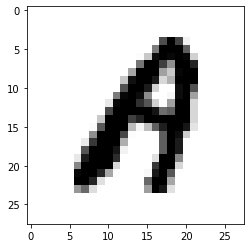

In [4]:
x = all_df.loc[0][1:].values
x = x.reshape((28, 28))
plt.imshow(x, cmap='binary')
plt.show()

In [5]:
all_df.head()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
all_df['0'].value_counts().sort_index()

0     13869
1      8668
2     23409
3     10134
4     11440
5      1163
6      5762
7      7218
8      1120
9      8493
10     5603
11    11586
12    12336
13    19010
14    57825
15    19341
16     5812
17    11566
18    48419
19    22495
20    29008
21     4182
22    10784
23     6272
24    10859
25     6076
Name: 0, dtype: int64

In [7]:
# load data from tensorflow framework
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(y_train.shape)

# Stack train data and test data to form single array 
mnist_data = np.vstack([x_train, x_test])
print(mnist_data.shape)
# Horizontal stacking labels of train and test set
mnist_labels = np.hstack([y_train, y_test])
print(mnist_labels.shape)

(60000, 28, 28)
(60000,)
(70000, 28, 28)
(70000,)


In [8]:
# Uniques and counts of train labels
unique_train, counts_train = np.unique(y_train, return_counts= True)
print(f"Value counts of y_train modalities: {counts_train}\n")

# Uniques and counts of test labels
unique_test, counts_test = np.unique(y_test, return_counts= True)
print(f"Value counts of y_test modalities: {counts_test}")

Value counts of y_train modalities: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]

Value counts of y_test modalities: [ 980 1135 1032 1010  982  892  958 1028  974 1009]


In [3]:
def load_az_dataset(datasetPath):
    # List for storing data
    data = []
  
    # List for storing labels
    labels = []
  
    for row in open(datasetPath): #Openfile and start reading each row
    #Split the row at every comma
        row = row.split(",")
    
        #row[0] contains label
        label = int(row[0])
    
        #Other all collumns contains pixel values make a saperate array for that
        image = np.array([int(x) for x in row[1:]], dtype="uint8")
        
        #Reshaping image to 28 x 28 pixels
        image = image.reshape((28, 28))
        
        #append image to data
        data.append(image)
        
        #append label to labels
        labels.append(label)
    
    #Converting data to numpy array of type float32
    data = np.array(data, dtype='float32')
  
    #Converting labels to type int
    labels = np.array(labels, dtype="int")
    
    return (data, labels)

In [4]:
# Load A-Z dataset
az_data, az_labels = load_az_dataset("./A_Z_Handwritten_Data/A_Z_Handwritten_Data.csv")

In [11]:
az_data.shape

(372451, 28, 28)

In [12]:
az_labels.shape

(372451,)

In [13]:
mnist_data

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [14]:
az_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [15]:
az_labels

array([ 0,  0,  0, ..., 25, 25, 25])

In [16]:
mnist_labels

array([5, 0, 4, ..., 4, 5, 6], dtype=uint8)

In [17]:
z = np.hstack([az_labels, mnist_labels])

In [18]:
z.shape

(442451,)

In [19]:
e = az_labels
e 

array([ 0,  0,  0, ..., 25, 25, 25])

In [20]:
a= az_labels
a

array([ 0,  0,  0, ..., 25, 25, 25])

In [5]:
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every A-Z label to ensure the A-Z characters are not incorrectly labeled 

az_labels += 10

# stack the A-Z data and labels with the MNIST digits data and labels

#data = np.vstack([az_data, mnist_data])
#labels = np.hstack([az_labels, mnist_labels])
labels = az_labels
# Each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# However, the architecture we're using is designed for 32x32 images,
# So we need to resize them to 32x32

data = [cv2.resize(image, (32, 32)) for image in az_data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]

data = np.expand_dims(data, axis=-1)
data /= 255.0

In [22]:
data.shape

(442451, 32, 32, 1)

In [23]:
labels

array([10, 10, 10, ...,  4,  5,  6])

In [6]:
le = LabelBinarizer()
labels = le.fit_transform(labels)

counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

In [7]:
classWeight

{0: 4.169069935111752,
 1: 6.671089063221043,
 2: 2.4702037677816224,
 3: 5.7060390763765545,
 4: 5.0546328671328675,
 5: 49.72055030094583,
 6: 10.035577924331829,
 7: 8.011221945137157,
 8: 51.629464285714285,
 9: 6.808548216178029,
 10: 10.320364090665715,
 11: 4.990937338166753,
 12: 4.6875,
 13: 3.0418200946870066,
 14: 1.0,
 15: 2.989762680316426,
 16: 9.94924294562973,
 17: 4.999567698426422,
 18: 1.1942625828703608,
 19: 2.5705712380529007,
 20: 1.993415609487038,
 21: 13.827116212338593,
 22: 5.362110534124629,
 23: 9.21954719387755,
 24: 5.3250759738465785,
 25: 9.51695194206715}

In [8]:
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels, test_size=0.20, stratify=labels, random_state=42)

In [9]:
trainX.shape

(297960, 32, 32, 1)

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.05,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
fill_mode="nearest")


In [11]:
batch_size = 128
epochs = 50

In [12]:
enet = ResNet50(
        input_shape=(32, 32, 1),
        weights=None,
        include_top=False
    )

model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(26, activation='softmax')
    ])


callbacks = [ModelCheckpoint(filepath='best_model.h5', save_weights_only = True,monitor='val_accuracy' ,mode='max')]
early = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose = 1)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23581440  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 26)                53274     
Total params: 23,634,714
Trainable params: 23,581,594
Non-trainable params: 53,120
_________________________________________________________________


In [13]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("using {} device".format(device))

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]= "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

C:\ProgramData\Anaconda3\envs\idip_2021\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using cuda device
Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [14]:
history = model.fit(
    aug.flow(trainX, trainY, batch_size=batch_size),
    epochs = epochs, 
    validation_data=(testX, testY),
    class_weight=classWeight,
    verbose=1,
    callbacks=[callbacks, early]).to(device)

Epoch 1/50
2328/2328 [==============================] - 456s 190ms/step - loss: 1.5422 - accuracy: 0.8916 - val_loss: 1.8958 - val_accuracy: 0.6858
Epoch 2/50
2328/2328 [==============================] - 453s 195ms/step - loss: 0.6853 - accuracy: 0.9512 - val_loss: 0.1245 - val_accuracy: 0.9646
Epoch 3/50
2328/2328 [==============================] - 454s 195ms/step - loss: 0.4764 - accuracy: 0.9653 - val_loss: 0.1354 - val_accuracy: 0.9599
Epoch 4/50
2328/2328 [==============================] - 447s 192ms/step - loss: 0.6163 - accuracy: 0.9549 - val_loss: 0.0896 - val_accuracy: 0.9738
Epoch 5/50
2328/2328 [==============================] - 442s 190ms/step - loss: 0.3653 - accuracy: 0.9729 - val_loss: 0.0758 - val_accuracy: 0.9774
Epoch 6/50
2328/2328 [==============================] - 469s 201ms/step - loss: 0.3408 - accuracy: 0.9742 - val_loss: 0.0881 - val_accuracy: 0.9763
Epoch 7/50
2328/2328 [==============================] - 472s 203ms/step - loss: 1.2197 - accuracy: 0.9366 - val_

AttributeError: 'History' object has no attribute 'to'

In [29]:
from keras.models import load_model

In [16]:
model.save('Resnet_Big.h5')

In [30]:
model_ex = load_model('Restnet_1.h5')

In [31]:
model_ex.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23581440  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 36)                73764     
Total params: 23,655,204
Trainable params: 23,602,084
Non-trainable params: 53,120
_________________________________________________________________


In [104]:
x_test = np.expand_dims(testX , axis =0)

In [35]:
testX.shape

(88491, 32, 32, 1)

In [36]:
yhat = model_ex.predict(testX)

In [37]:
yhat.shape

(88491, 36)

In [46]:
np.argmax(yhat[3])

22

In [50]:
testY_1[3]

22

In [48]:
testY_1 = le.inverse_transform(testY)

In [52]:
for i in range(10):
    print("%d predict : %d  %d  target : %d \n"%(i , np.argmax(yhat[i]) , i , testY_1[i]) )

0 predict : 24  0  target : 24 

1 predict : 35  1  target : 35 

2 predict : 29  2  target : 29 

3 predict : 22  3  target : 22 

4 predict : 4  4  target : 4 

5 predict : 6  5  target : 6 

6 predict : 30  6  target : 30 

7 predict : 16  7  target : 16 

8 predict : 12  8  target : 12 

9 predict : 35  9  target : 35 



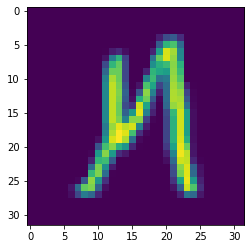

In [66]:
plt.imshow(testX[3])

In [67]:
print(np.argmax(yhat[3]))

22


In [68]:
testY_1[3]

22